# Age Estimation using Pixel Difference in Convolution Regression

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchsummary import summary
from torchvision import transforms, datasets
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader, random_split
from collections import Counter

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
import shutil

import copy

from pathlib import Path
from datetime import datetime

from torch.utils.tensorboard import SummaryWriter

## Age estimation in age groups

### Set image size and variables 

In [2]:
IMAGE_SIZE = [200,200]
BASE_DIR = './UTKFace/'
NR_EPOCHS = 80
BATCH_SIZE = 30

### Read input dataset and split into training, validation and test set  

In [3]:
class UTKFaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = [file for file in os.listdir(root_dir) if file.endswith('.jpg') or file.endswith('.png')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(img_name)
        
        age = int(self.images[idx].split('_')[0])
        
        if self.transform:
            image = self.transform(image)
        
        return image, age

# transform
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# laod dataset
full_dataset = UTKFaceDataset(root_dir=BASE_DIR, transform=transform)

# split dataset accordingly 
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# fixed seed for same split across models
generator = torch.Generator().manual_seed(116)

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size], generator=generator
)

In [4]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Print some information
print(f"Total dataset size: {total_size}")
print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Total dataset size: 23708
Train set size: 16595
Validation set size: 3556
Test set size: 3557


## Normal Model

In [5]:
# Set CUDA_LAUNCH_BLOCKING for synchronous CUDA operations
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Check CUDA availability and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### Create Model

In [6]:
## https://github.com/hellozhuo/pidinet/blob/master/models/ops.py

class Conv2d(nn.Module):
    def __init__(self, pdc, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=False):
        super(Conv2d, self).__init__()
        if in_channels % groups != 0:
            raise ValueError('in_channels must be divisible by groups')
        if out_channels % groups != 0:
            raise ValueError('out_channels must be divisible by groups')
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.groups = groups
        self.weight = nn.Parameter(torch.Tensor(out_channels, in_channels // groups, kernel_size, kernel_size))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
        self.pdc = self.create_conv_func(pdc)

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

    def create_conv_func(self, op_type):
        if op_type == 'cv':
            return F.conv2d
        elif op_type == 'cd':
            return self.cd_conv
        elif op_type == 'ad':
            return self.ad_conv
        elif op_type == 'rd':
            return self.rd_conv
        else:
            raise ValueError(f"Unknown op type: {op_type}")

    def cd_conv(self, x, weights, bias=None, stride=1, padding=0, dilation=1, groups=1):
        assert dilation in [1, 2], 'dilation for cd_conv should be in 1 or 2'
        assert weights.size(2) == 3 and weights.size(3) == 3, 'kernel size for cd_conv should be 3x3'
        assert padding == dilation, 'padding for cd_conv set wrong'
        
        weights_c = weights.sum(dim=[2, 3], keepdim=True)
        yc = F.conv2d(x, weights_c, stride=stride, padding=0, groups=groups)
        y = F.conv2d(x, weights, bias, stride=stride, padding=padding, dilation=dilation, groups=groups)
        return y - yc

    def ad_conv(self, x, weights, bias=None, stride=1, padding=0, dilation=1, groups=1): 
        assert dilation in [1, 2], 'dilation for ad_conv should be in 1 or 2'
        assert weights.size(2) == 3 and weights.size(3) == 3, 'kernel size for ad_conv should be 3x3'
        assert padding == dilation, 'padding for ad_conv set wrong'
        
        shape = weights.shape
        weights = weights.view(shape[0], shape[1], -1)
        weights_conv = (weights - weights[:, :, [3, 0, 1, 6, 4, 2, 7, 8, 5]]).view(shape)
        y = F.conv2d(x, weights_conv, bias, stride=stride, padding=padding, dilation=dilation, groups=groups)
        return y

    def rd_conv(self, x, weights, bias=None, stride=1, padding=0, dilation=1, groups=1):
        assert dilation in [1, 2], 'dilation for rd_conv should be in 1 or 2'
        assert weights.size(2) == 3 and weights.size(3) == 3, 'kernel size for rd_conv should be 3x3'
        
        padding = 2 * dilation
        shape = weights.shape
        if weights.is_cuda:
            buffer = torch.cuda.FloatTensor(shape[0], shape[1], 5 * 5).fill_(0)
        else:
            buffer = torch.zeros(shape[0], shape[1], 5 * 5)
        weights = weights.view(shape[0], shape[1], -1)
        buffer[:, :, [0, 2, 4, 10, 14, 20, 22, 24]] = weights[:, :, 1:]
        buffer[:, :, [6, 7, 8, 11, 13, 16, 17, 18]] = -weights[:, :, 1:]
        buffer[:, :, 12] = 0
        buffer = buffer.view(shape[0], shape[1], 5, 5)
        y = F.conv2d(x, buffer, bias, stride=stride, padding=padding, dilation=dilation, groups=groups)
        return y

    def forward(self, input):
        input = input.to(self.weight.device)
        return self.pdc(input, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)

class PDCBlock(nn.Module):
    def __init__(self, pdc, inplane, outplane, stride=1):
        super(PDCBlock, self).__init__()
        self.stride = stride
        
        if self.stride > 1:
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
            self.shortcut = nn.Conv2d(inplane, outplane, kernel_size=1, padding=0)
        
        self.conv1 = Conv2d(pdc, inplane, inplane, kernel_size=3, padding=1, groups=inplane, bias=False)
        self.relu2 = nn.ReLU()
        self.conv2 = nn.Conv2d(inplane, outplane, kernel_size=1, padding=0, bias=False)

    def forward(self, x):
        if self.stride > 1:
            x = self.pool(x)
        y = self.conv1(x)
        y = self.relu2(y)
        y = self.conv2(y)
        if self.stride > 1:
            x = self.shortcut(x)
        y = y + x
        return y

class PDCModel(nn.Module):
    def __init__(self):
        super(PDCModel, self).__init__()
        ##  using short version of 'carv4' cd, ad, rd, cv
        self.features = nn.Sequential(
            PDCBlock('cd', 3, 96, stride=2), 
            nn.BatchNorm2d(96),
            nn.ReLU(),
            
            PDCBlock('ad', 96, 256, stride=2), 
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            PDCBlock('rd', 256, 384, stride=2), 
            nn.BatchNorm2d(384),
            nn.ReLU(),
            
            PDCBlock('cv', 384, 384, stride=1),  
            nn.BatchNorm2d(384),
            nn.ReLU(),
            
            nn.AdaptiveAvgPool2d((1, 1)) 
        )
        
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(384, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, 1)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.regressor(x)
        return x.squeeze(dim=1)

# Instantiate the model
model = PDCModel().to(device)

# Print model summary
print(model)

summary(model,(3,200,200))
# Test the model with a sample input
sample_input = torch.randn(1, 3, 200, 200).to(device)
output = model(sample_input)
print(f"Output shape: {output.shape}")

PDCModel(
  (features): Sequential(
    (0): PDCBlock(
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (shortcut): Conv2d(3, 96, kernel_size=(1, 1), stride=(1, 1))
      (conv1): Conv2d()
      (relu2): ReLU()
      (conv2): Conv2d(3, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): PDCBlock(
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (shortcut): Conv2d(96, 256, kernel_size=(1, 1), stride=(1, 1))
      (conv1): Conv2d()
      (relu2): ReLU()
      (conv2): Conv2d(96, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): PDCBlock(
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (shortcut): Conv2d(256, 384, 

/tmp/ipykernel_4696/1469704417.py:72: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:78.)
  buffer = torch.cuda.FloatTensor(shape[0], shape[1], 5 * 5).fill_(0)


In [7]:
writer = SummaryWriter('./Project/classes/runs/pdc-regression', comment='PDC_Regression_Model')
writer.add_graph(model, sample_input)

/tmp/ipykernel_4696/1469704417.py:46: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert weights.size(2) == 3 and weights.size(3) == 3, 'kernel size for cd_conv should be 3x3'
/tmp/ipykernel_4696/1469704417.py:56: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert weights.size(2) == 3 and weights.size(3) == 3, 'kernel size for ad_conv should be 3x3'
/tmp/ipykernel_4696/1469704417.py:67: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be 

In [8]:
# here use a lower learning rate since it turns to NaN
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
loss_fn = torch.nn.MSELoss(reduction='mean')
loss_fn = loss_fn.to(device)

### Train model

In [9]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs, summary_writer, device, save_path):
    
    # create history for graphs
    history = {
        'train_mae': [],
        'val_mae': [],
        'train_loss': [],
        'val_loss': []
    }

    # create cuda events for timetracking
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    
    # init variables for saving
    best_val_mae = float('Inf')
    best_model_wts = copy.deepcopy(model.state_dict()) 

    start.record()
    for epoch in range(epochs):
        train_loss = 0.0
        val_loss = 0.0
        num_train = 0
        train_mae_sum = 0.0
           
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)
            targets = targets.float().view(-1)

            inputs = torch.nan_to_num(inputs)
            outputs = model(inputs)
            
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
            num_train += targets.size(0)
            abs_error_train = torch.abs(outputs - targets)
            train_mae_sum += abs_error_train.sum().item()

                
        train_loss /= num_train
        train_mae = train_mae_sum / num_train

        if epoch+1 == NR_EPOCHS:
            end.record()
            torch.cuda.synchronize()
        
        model.eval()
        num_val = 0
        val_mae_sum = 0.0
        
        with torch.no_grad():
            for batch in val_loader:
                inputs, targets = batch
                inputs, targets = inputs.to(device), targets.to(device)
                targets = targets.float().view(-1)
                outputs = model(inputs)
                
                loss = loss_fn(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
                num_val += targets.size(0)
                
                abs_error_val = torch.abs(outputs - targets)
                val_mae_sum += abs_error_val.sum().item()
        
        val_loss /= num_val
        val_mae = val_mae_sum / num_val

        summary_writer.add_scalar('Train Loss', train_loss, epoch+1)
        summary_writer.add_scalar('Val Loss', val_loss, epoch+1)
        summary_writer.add_scalar('Train MAE', train_mae, epoch+1)
        summary_writer.add_scalar('Val MAE', val_mae, epoch+1)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_mae'].append(train_mae)
        history['val_mae'].append(val_mae)
        
        print(f'Epoch: [{epoch+1}/{NR_EPOCHS}], Training Loss: {train_loss:.2f}, Validation Loss: {val_loss:.2f}, '
              f'Training MAE: {train_mae:.2f}, Validation MAE: {val_mae:.2f}')
        
        # save best model if MAE improves
        if val_mae < best_val_mae:
            best_val_mae = val_mae
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, save_path)
            print(f"Best model saved at epoch {epoch+1} with validation MAE: {best_val_mae:.2f}")
            
    print(f'Training time:  {round(start.elapsed_time(end) / 60000, 1)} minutes')
    return history


In [10]:
# train model 
history = train(model, optimizer, loss_fn, train_loader, val_loader, NR_EPOCHS, writer, device, './Project/regression/pdc/pdc_regression_model')
writer.close()

Epoch: [1/80], Training Loss: 351.72, Validation Loss: 220.40, Training MAE: 14.29, Validation MAE: 11.29
Best model saved at epoch 1 with validation MAE: 11.29
Epoch: [2/80], Training Loss: 249.60, Validation Loss: 204.30, Training MAE: 12.11, Validation MAE: 10.91
Best model saved at epoch 2 with validation MAE: 10.91
Epoch: [3/80], Training Loss: 224.93, Validation Loss: 217.64, Training MAE: 11.41, Validation MAE: 11.52
Epoch: [4/80], Training Loss: 208.20, Validation Loss: 175.89, Training MAE: 10.89, Validation MAE: 9.92
Best model saved at epoch 4 with validation MAE: 9.92
Epoch: [5/80], Training Loss: 195.71, Validation Loss: 189.88, Training MAE: 10.50, Validation MAE: 10.98
Epoch: [6/80], Training Loss: 188.09, Validation Loss: 158.01, Training MAE: 10.25, Validation MAE: 9.35
Best model saved at epoch 6 with validation MAE: 9.35
Epoch: [7/80], Training Loss: 176.38, Validation Loss: 149.43, Training MAE: 9.88, Validation MAE: 8.98
Best model saved at epoch 7 with validation 

### Training History

In [11]:
def plot_history(history, path_name):
    # loss
    loss_train = history['train_loss']
    loss_val = history['val_loss']
    epochs = range(NR_EPOCHS)
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(path_name + '_loss.png', bbox_inches='tight')
    plt.show()

    # accuracy
    mae_train = history['train_mae']
    mae_val = history['val_mae']
    epochs = range(NR_EPOCHS)
    plt.plot(epochs, mae_train, 'g', label='Training MAE')
    plt.plot(epochs, mae_val, 'b', label='Validation MAE')
    plt.title('Training and validation mean absolute error')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.savefig(path_name + '_mae.png', bbox_inches='tight')
    plt.show()


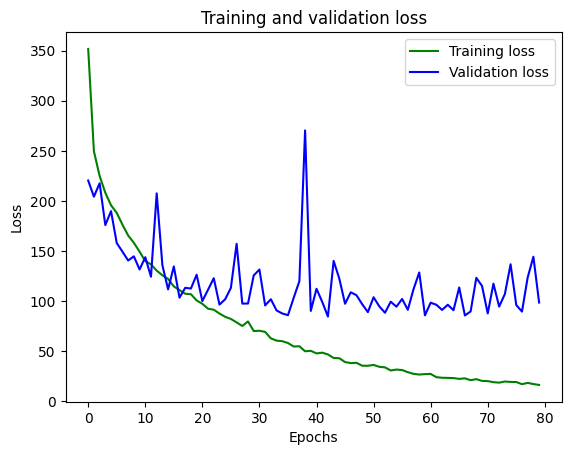

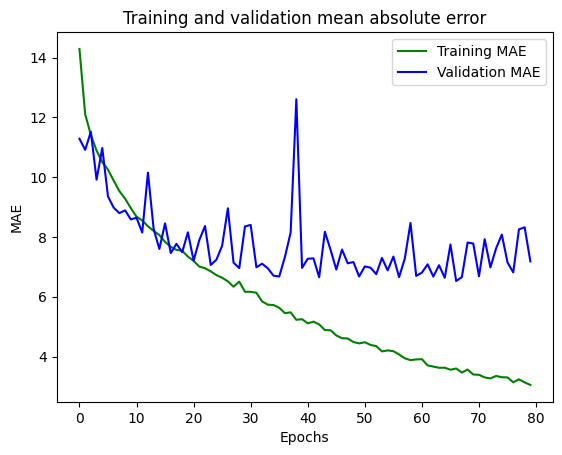

In [12]:
plot_history(history,'./Project/regression/pdc/pdc_regression_model')

### Test Model

In [13]:
def test(model, test_loader, loss_fn ,name):
    test_loss = 0
    test_mae_sum = 0
    test_total = 0
    total_absolute_test_errors = torch.zeros(3)

    # create cuda events for timetracking
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    start.record()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().view(-1)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            test_total += labels.size(0)
            abs_error_test = torch.abs(outputs - labels)
            test_mae_sum += abs_error_test.sum().item()

            total_absolute_test_errors[0] += (abs_error_test <= 1).sum().item()
            total_absolute_test_errors[1] += (abs_error_test <= 5).sum().item()
            total_absolute_test_errors[2] += (abs_error_test <= 10).sum().item()

    end.record()
    torch.cuda.synchronize()
    test_loss /= test_total
    test_mae = test_mae_sum / test_total
    within_years = total_absolute_test_errors / test_total

    print(f'Model: {name},  Test Loss: {test_loss:.2f}, Test MAE: {test_mae:.2f}')
    print(f'Within 1 year: {within_years[0]:.2%}')
    print(f'Within 5 years: {within_years[1]:.2%}')
    print(f'Within 10 years: {within_years[2]:.2%}')
    print(f'Time:  {round(start.elapsed_time(end), 1) / 1000} seconds')

In [15]:
# load models
pdc_regression_model = PDCModel().to(device)
pdc_regression_model.load_state_dict(torch.load('./Project/regression/pdc/pdc_regression_model'))

test(pdc_regression_model.to(device), test_loader, loss_fn, 'PDCNet')

Model: PDCNet,  Test Loss: 98.51, Test MAE: 6.98
Within 1 year: 13.64%
Within 5 years: 51.34%
Within 10 years: 75.60%
Time:  3.2209 seconds
